## Accessing Llama 3 via Hugging Face

 Environment Setup

In [1]:
# Create a virtual environment (optional but recommended)
!python -m venv llama-lab
!source llama-lab/bin/activate   # On Windows: llama-lab\Scripts\activate
# Install required packages
!pip install transformers torch pandas matplotlib numpy accelerate bitsandbytes

Error: Command '['/content/llama-lab/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: llama-lab/bin/activate: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00

API Configuration

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Set your Hugging Face token
os.environ["HUGGINGFACE_TOKEN"] = "YOUR_HF_TOKEN"  # Replace with your actual token

# Alternatively, you can login via the CLI with: huggingface-cli login

Loading Llama 3

In [9]:
def initialize_llama3(model_id="meta-llama/Llama-3.2-1B-Instruct", use_4bit=True):
    """
    Initialize Llama 3 model from Hugging Face.

    Args:
        model_id (str): Hugging Face model ID.
        use_4bit (bool): Whether to use 4-bit quantization for memory efficiency.

    Returns:
        tuple: (model, tokenizer, pipeline)
    """
    print(f"Loading {model_id}...")

    tokenizer = AutoTokenizer.from_pretrained(
        model_id,
        token=os.environ.get("HUGGINGFACE_TOKEN")
    )

    if use_4bit:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            token=os.environ.get("HUGGINGFACE_TOKEN"),
            # Remove redundant load_in_4bit argument
            # load_in_4bit=True,
            quantization_config={
                "load_in_4bit": True,
                "bnb_4bit_compute_dtype": torch.bfloat16,
                "bnb_4bit_quant_type": "nf4",
                "bnb_4bit_use_double_quant": True,
            }
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            token=os.environ.get("HUGGINGFACE_TOKEN")
        )

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False
    )

    return model, tokenizer, pipe

# Initialize the model
model, tokenizer, llama3_pipe = initialize_llama3()

Loading meta-llama/Llama-3.2-1B-Instruct...


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


Helper Functions

In [10]:
def query_llm(prompt, max_new_tokens=500, temperature=0.7):
    """
    Send a prompt to Llama 3 and get a response.

    Args:
        prompt (str): The prompt to send to the model.
        max_new_tokens (int): Maximum length of the response.
        temperature (float): Controls randomness (0–1).

    Returns:
        str: The model's response.
    """
    try:
        # Format the prompt according to Llama 3's chat template
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

        # Generate the response
        result = llama3_pipe(
            formatted_prompt,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.9
        )

        return result[0]["generated_text"]
    except Exception as e:
        print(f"Error querying Llama 3: {e}")
        return None


def calculate_response_metrics(response):
    """
    Calculate basic metrics about the response.

    Args:
        response (str): The model's response.

    Returns:
        dict: Dictionary of metrics.
    """
    metrics = {
        "word_count": len(response.split()),
        "char_count": len(response),
        "sentence_count": response.count('. ') + response.count('! ') + response.count('? ')
    }
    return metrics


Quick Test

In [11]:
# Test the Llama 3 setup
test_prompt = "What is prompt engineering?"
response = query_llm(test_prompt)
print(response)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


assistant

Prompt engineering is the process of designing and crafting effective and coherent prompts that are used to generate human-like responses from AI models, such as language generators, chatbots, and other conversational interfaces. The goal of prompt engineering is to create prompts that are clear, concise, and context-specific, allowing AI models to generate accurate and relevant responses.

Effective prompt engineering involves several key considerations:

1. **Understanding the context**: The prompt should provide enough context to allow the AI model to understand the topic, intent, or task at hand.
2. **Keyword selection**: Choosing the right keywords, phrases, or tokens can significantly impact the quality of the response.
3. **Conversational flow**: The prompt should guide the AI model through a natural conversation flow, avoiding awkward or unnatural transitions.
4. **Tone and style**: The tone and style of the prompt should match the desired conversational tone and sty

### Zero-shot vs. Few-shot Prompting

Setup for Comparison

In [13]:
# Define a set of tasks for comparison
tasks = [
    "Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'",
    "Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'",
    "Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'",
    "Determine if this statement is a fact or opinion: 'Coffee is the best beverage for morning productivity.'"
]

# Define few-shot examples for each task
few_shot_examples = {
    "sentiment": [
        {"example": "The movie was fantastic and I enjoyed every minute.", "label": "Positive"},
        {"example": "The hotel room was dirty and the staff was rude.", "label": "Negative"},
        {"example": "While the price was high, the quality was worth it.", "label": "Positive"}
    ],
    "emotion": [
        {"example": "I just won the lottery!", "label": "Joy"},
        {"example": "My dog passed away yesterday.", "label": "Sadness"},
        {"example": "They didn't invite me to the party.", "label": "Disappointment"}
    ],
    "categorization": [
        {"example": "Local election results surprise analysts.", "label": "Politics"},
        {"example": "New movie breaks box office records.", "label": "Entertainment"},
        {"example": "Team wins championship for the third time.", "label": "Sports"}
    ],
    "fact_opinion": [
        {"example": "The Earth orbits around the Sun.", "label": "Fact"},
        {"example": "Summer is the best season of the year.", "label": "Opinion"},
        {"example": "Chocolate contains caffeine.", "label": "Fact"}
    ]
}


 Implementing Zero-shot Prompting

In [14]:
def zero_shot_prompt(task):
    """
    Perform zero-shot prompting for a given task.

    Args:
        task (str): The task to perform.

    Returns:
        str: The model's response.
    """
    return query_llm(task)

# Test zero-shot prompting on our tasks
zero_shot_results = []

for task in tasks:
    response = zero_shot_prompt(task)
    result = {
        "task": task,
        "response": response,
        "metrics": calculate_response_metrics(response) if response else None
    }
    zero_shot_results.append(result)

    print(f"Task: {task}")
    print(f"Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'
Response: assistant

This review is mixed. It's negative in that the reviewer mentions "terrible" service, but positive in that the food was "amazing."



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'
Response: assistant

The emotion expressed in this sentence is disappointment or frustration. The speaker is expressing their disappointment and frustration with not passing the exam despite their hard work and effort.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'
Response: assistant

I would categorize this news headline as 'politics'.

Task: Determine if this statement is a fact or opinion: 'Coffee is the best beverage for morning productivity.'
Response: assistant

This statement is an opinion. 

While coffee can be beneficial for some people's morning routines, it is not universally agreed upon as the best beverage for morning productivity. Different people may have different preferences, and what works for one person may not work for another. Additionally, there may be other factors, such as individual sensitivity to caffeine or certain health conditions, that can affect how coffee affects someone's productivity.



Implementing Few-shot Prompting

In [15]:
def few_shot_prompt(task, examples):
    """
    Perform few-shot prompting for a given task.

    Args:
        task (str): The task to perform.
        examples (list): List of example dictionaries with 'example' and 'label' keys.

    Returns:
        str: The model's response.
    """
    # Construct the prompt with examples
    prompt = "Here are some examples:\n\n"

    for example in examples:
        prompt += f"Input: {example['example']}\nOutput: {example['label']}\n\n"

    input_text = task.split(': ', 1)[1] if ': ' in task else task
    prompt += f"Input: {input_text}\nOutput:"

    return query_llm(prompt)

# Determine which examples to use for each task
task_to_examples = {
    0: "sentiment",
    1: "emotion",
    2: "categorization",
    3: "fact_opinion"
}

# Test few-shot prompting on our tasks
few_shot_results = []

for i, task in enumerate(tasks):
    example_type = task_to_examples[i]
    examples = few_shot_examples[example_type]

    response = few_shot_prompt(task, examples)

    few_shot_results.append({
        "task": task,
        "response": response,
        "metrics": calculate_response_metrics(response) if response else None,
        "example_type": example_type
    })

    print(f"Task: {task}")
    print(f"Examples used: {example_type}")
    print(f"Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'
Examples used: sentiment
Response: assistant

It seems like you're looking for a sentiment analysis tool. Based on the examples you provided, here are some possible outputs for the examples you gave:

Input: The movie was fantastic and I enjoyed every minute.
Output: Positive

Input: The hotel room was dirty and the staff was rude.
Output: Negative

Input: While the price was high, the quality was worth it.
Output: Neutral

Input: 'The service was terrible but the food was amazing.'
Output: Neutral

It appears that your goal is to generate responses that are generally positive, as you mentioned enjoying every minute of a good experience. However, the responses you provided earlier were neutral or negative. To improve, I could suggest some possible improvements:

1. Adding a positive phrase to each sentence:
Input: The movie was fantastic and I enjoyed every minute.
Output: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'
Examples used: emotion
Response: assistant

Based on the patterns observed from the examples, I'll try to infer the correct output.

From the examples:

1. "I just won the lottery!" - Joy
2. "My dog passed away yesterday." - Sadness
3. "They didn't invite me to the party." - Disappointment

It seems that the sentiment is the opposite of what the word or phrase typically means. Here's a possible pattern:

- Joy (excitement or happiness) is not always associated with winning a lottery.
- Sadness is often associated with the loss of something, not the gain.
- Disappointment is usually associated with a missed opportunity, not an actual event that occurred.

If I apply this pattern to the given examples, here's what I would expect the output to be for the new input:

Input: I had a meeting with a potential investor.
Output:



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'
Examples used: categorization
Response: assistant

It seems like you're trying to predict the output based on the input. 

The pattern appears to be that the input is related to a specific topic, and the output is the opposite topic. 

Let's break it down:

- Local election results surprise analysts: 
  - Local = Local (Geographic location)
  - Election results = Politics
  - Surprise analysts = Analysis (Concerns or insights about the outcome)

- New movie breaks box office records:
  - New = New (Something new)
  - Movie = Entertainment
  - Box office records = Box office (A measure of a movie's success)

- Team wins championship for the third time:
  - Team = Team (A group of people)
  - Championship = Sports
  - Wins championship = Wins (Success in a competitive event)

- 'New trade agreement signed between countries.'
  - New = New (Something new)
  - Trade ag

Comparing Results

In [16]:
# Create a comparison dataframe
comparison_data = []

for i in range(len(tasks)):
    comparison_data.append({
        "Task": tasks[i],
        "Zero-shot Response": zero_shot_results[i]["response"],
        "Few-shot Response": few_shot_results[i]["response"]
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# You can also save this to a CSV for further analysis
comparison_df.to_csv("zero_shot_vs_few_shot_comparison.csv", index=False)

                                                Task  \
0  Classify the following review as positive or n...   
1  Identify the emotion in this sentence: 'I can'...   
2  Categorize this news headline as politics, spo...   
3  Determine if this statement is a fact or opini...   

                                  Zero-shot Response  \
0  assistant\n\nThis review is mixed. It's negati...   
1  assistant\n\nThe emotion expressed in this sen...   
2  assistant\n\nI would categorize this news head...   
3  assistant\n\nThis statement is an opinion. \n\...   

                                   Few-shot Response  
0  assistant\n\nIt seems like you're looking for ...  
1  assistant\n\nBased on the patterns observed fr...  
2  assistant\n\nIt seems like you're trying to pr...  
3  assistant\n\nIt seems like you're trying to te...  


In [17]:
comparison_df

,Task,Zero-shot Response,Few-shot Response
0,Classify the following review as positive or n...,assistant\n\nThis review is mixed. It's negati...,assistant\n\nIt seems like you're looking for ...
1,Identify the emotion in this sentence: 'I can'...,assistant\n\nThe emotion expressed in this sen...,assistant\n\nBased on the patterns observed fr...
2,"Categorize this news headline as politics, spo...",assistant\n\nI would categorize this news head...,assistant\n\nIt seems like you're trying to pr...
3,Determine if this statement is a fact or opini...,assistant\n\nThis statement is an opinion. \n\...,assistant\n\nIt seems like you're trying to te...


## Chain-of-Thought (CoT) Prompting

Problem Set for Testing

In [18]:
# Define a set of reasoning problems
reasoning_problems = [
    "If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?",
    "A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?",
    "If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?",
    "A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?"
]

Standard Prompting

In [19]:
def standard_prompt(problem):
    """
    Perform standard prompting for a reasoning problem.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = f"Answer the following question: {problem}"
    return query_llm(prompt)

# Test standard prompting on our reasoning problems
standard_results = []
for problem in reasoning_problems:
    response = standard_prompt(problem)
    standard_results.append({
        "problem": problem,
        "response": response
    })
    print(f"Problem: {problem}")
    print(f"Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?
Response: assistant

To find the final price, we need to calculate the discount amount first.

The original price is $100. 
25% off: $100 x 0.25 = $25
Discounted price: $100 - $25 = $75

Now, we add the additional 10% discount to the discounted price:
$75 + 10% of $75
$75 + ($75 x 0.10)
$75 + $7.50
$82.50

The final price is $82.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
Response: assistant

To find the distance traveled by the train, you need to multiply the speed (60 miles per hour) by the time (2.5 hours).

Distance = Speed x Time
= 60 miles/hour x 2.5 hours
= 150 miles

The train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
Response: assistant

If it takes 5 machines 5 minutes to make 5 widgets, we can start by determining the rate at which one machine makes widgets. 

5 widgets / 5 minutes = 1 widget per minute per machine

Now, we can multiply this rate by the number of machines to get the total rate:

1 widget per minute per machine * 100 machines = 100 widgets per minute

Since it takes 5 minutes to make 100 widgets, we can divide 100 by 100 to get the time it takes for 100 machines:

100 widgets / 100 machines = 1 minute

Therefore, it would take 100 machines 1 minute to make 100 widgets.

Problem: A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
Response: assistant

Let's use algebra to solve this problem.

Let the cost of the ball be x. Since the bat costs $1.00 more than the ball, the cost of the bat is x + $1.00.

We know t

Chain-of-Thought Prompting

In [20]:
def cot_prompt(problem):
    """
    Perform Chain-of-Thought prompting for a reasoning problem.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = f"Answer the following question by thinking step by step: {problem}"
    return query_llm(prompt)

# Test CoT prompting on our reasoning problems
cot_results = []
for problem in reasoning_problems:
    response = cot_prompt(problem)
    cot_results.append({
        "problem": problem,
        "response": response
    })
    print(f"Problem: {problem}")
    print(f"CoT Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?
CoT Response: assistant

To find the final price, let's break it down step by step:

1. The original price of the shirt is $100.
2. The first discount is 25%. To find the amount of the discount, multiply the original price by the discount percentage:
   25% of $100 = 0.25 x $100 = $25
   The discount is $25.
3. Subtract the discount from the original price to find the price after the first discount:
   $100 - $25 = $75
4. The second discount is 10%. To find the amount of the second discount, multiply the price after the first discount by the second discount percentage:
   10% of $75 = 0.10 x $75 = $7.50
   The second discount is $7.50.
5. Subtract the second discount from the price after the first discount:
   $75 - $7.50 = $67.50

So, the final price of the shirt is $67.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
CoT Response: assistant

To find the distance traveled by the train, we need to multiply the speed of the train by the time it travels.

Speed = 60 miles per hour
Time = 2.5 hours

Distance = Speed x Time
= 60 miles/hour x 2.5 hours
= 150 miles

So, the train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
CoT Response: assistant

Let's break down the problem step by step:

1. If it takes 5 machines 5 minutes to make 5 widgets, we need to find the rate of production per machine.
2. Since the total output is 5 widgets and it takes 5 machines 5 minutes, the total time to produce 1 widget is 5 minutes per machine.
3. Now, we need to calculate the total time to produce 100 widgets with 100 machines.
4. We know that the rate of production per machine is 1 widget per 5 minutes, so the rate per machine is 1/5 widgets per minute.
5. Now, we need to find the total time to produce 100 widgets with 100 machines.
6. Since the rate per machine is 1/5 widgets per minute, the total time to produce 100 widgets with 100 machines is 100 / (1/5) = 100 * 5 = 500 minutes.

Therefore, it would take 100 machines 500 minutes to make 100 widgets.

Problem: A bat and a ball cost $1.10 in total. Th

Few-shot Chain-of-Thought

In [21]:
def few_shot_cot_prompt(problem):
    """
    Perform few-shot Chain-of-Thought prompting.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = """I'll solve some math problems step by step.
Problem: If John has 5 apples and gives 2 to Mary, how many apples does John have left?
Solution: John starts with 5 apples. He gives 2 apples to Mary. So, John has 5 - 2 = 3 apples left.

Problem: A rectangle has a length of 10 cm and a width of 5 cm. What is its area?
Solution: The area of a rectangle is calculated by multiplying length × width. So, the area is 10 cm × 5 cm = 50 square cm.

Problem: If a car travels at 60 miles per hour, how far will it travel in 2 hours?
Solution: Distance = Speed × Time. So, the car will travel 60 miles/hour × 2 hours = 120 miles.

Problem: {}
Solution:""".format(problem)

    return query_llm(prompt)

# Test few-shot CoT prompting on our reasoning problems
few_shot_cot_results = []
for problem in reasoning_problems:
    response = few_shot_cot_prompt(problem)
    few_shot_cot_results.append({
        "problem": problem,
        "response": response
    })
    print(f"Problem: {problem}")
    print(f"Few-shot CoT Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?
Few-shot CoT Response: assistant

To find the final price, we need to first calculate the discount from the original price.

Original price = $100
Discount = 25% of $100 = 0.25 × $100 = $25
Discounted price = Original price - Discount = $100 - $25 = $75

Next, we apply the additional 10% discount:
Additional discount = 10% of $75 = 0.10 × $75 = $7.50
Final price = Discounted price - Additional discount = $75 - $7.50 = $67.50

So, the final price of the shirt is $67.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
Few-shot CoT Response: assistant

I can help you solve the next problem. Here's the step-by-step solution:

Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?

Solution: To find the distance traveled, we multiply the speed by the time.

Distance = Speed × Time
= 60 miles/hour × 2.5 hours
= 60 × 2.5
= 150 miles

So, the train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
Few-shot CoT Response: assistant

To solve this problem, we need to determine the rate at which the machines work and then apply it to the larger quantity.

First, let's analyze the given information:
- 5 machines take 5 minutes to make 5 widgets.
- We need to find the time it takes for 100 machines to make 100 widgets.

Since the machines work at the same rate, we can determine the rate at which one machine works:
- 5 machines make 5 widgets in 5 minutes. To find the rate per minute, we can divide the number of widgets by the number of minutes:
  Rate per minute = 5 widgets / 5 minutes = 1 widget/minute
- Now, to find the rate for 100 machines, we can multiply the rate per minute by 100:
  Rate for 100 machines = 1 widget/minute × 100 machines = 100 widgets/minute

Since 1 widget is equal to 1 unit, we can find the time it takes for 100 machines to make 100 widgets:
- 

Comparing Approaches

In [22]:
def extract_final_answer(response):
    """
    Attempt to extract just the final numerical answer from a response.
    This is a simple implementation and may need refinement for complex responses.

    Args:
        response (str): The model's full response

    Returns:
        str: The extracted final answer, or the original response if extraction fails
    """
    # Look for common patterns in answers
    if "$" in response:
        # Try to find monetary amounts
        import re
        matches = re.findall(r'\$\d+\.?\d*', response)
        if matches:
            return matches[-1]  # Return the last monetary amount found

    # Look for the last sentence that might contain the answer
    sentences = response.split('.')
    for sentence in reversed(sentences):
        if any(word in sentence.lower() for word in ['answer', 'result', 'therefore', 'so', 'thus', 'final']):
            return sentence.strip()

    # If we can't extract a specific answer, return the last sentence
    if sentences:
        return sentences[-1].strip()

    return response

# Compare the approaches
comparison_data = []
for i in range(len(reasoning_problems)):
    standard_answer = extract_final_answer(standard_results[i]["response"])
    cot_answer = extract_final_answer(cot_results[i]["response"])
    few_shot_cot_answer = extract_final_answer(few_shot_cot_results[i]["response"])

    comparison_data.append({
        "Problem": reasoning_problems[i],
        "Standard Answer": standard_answer,
        "CoT Answer": cot_answer,
        "Few-shot CoT Answer": few_shot_cot_answer
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save the comparison to a CSV for further analysis
comparison_df.to_csv("cot_comparison.csv", index=False)

                                             Problem  \
0  If a shirt originally costs $100 and is on sal...   
1  A train travels at a speed of 60 miles per hou...   
2  If it takes 5 machines 5 minutes to make 5 wid...   
3  A bat and a ball cost $1.10 in total. The bat ...   

                                     Standard Answer  \
0                                             $82.50   
1                                                      
2  5 widgets / 5 minutes = 1 widget per minute pe...   
3                                              $0.05   

                                          CoT Answer  \
0                                             $67.50   
1  5 hours\n= 150 miles\n\nSo, the train will tra...   
2  Therefore, it would take 100 machines 500 minu...   
3                                              $0.05   

                                 Few-shot CoT Answer  
0                                             $67.50  
1  5\n= 150 miles\n\nSo, the train will travel 

In [23]:
comparison_df

,Problem,Standard Answer,CoT Answer,Few-shot CoT Answer
0,If a shirt originally costs $100 and is on sal...,$82.50,$67.50,$67.50
1,A train travels at a speed of 60 miles per hou...,,"5 hours\n= 150 miles\n\nSo, the train will tra...","5\n= 150 miles\n\nSo, the train will travel 15..."
2,If it takes 5 machines 5 minutes to make 5 wid...,5 widgets / 5 minutes = 1 widget per minute pe...,"Therefore, it would take 100 machines 500 minu...","To find the rate per minute, we can divide the..."
3,A bat and a ball cost $1.10 in total. The bat ...,$0.05,$0.05,$0.05


## Tree of Thoughts Implementation

Decision Problems for Testing

In [24]:
decision_problems = [
    "Should a small business invest in expensive automation technology or hire more staff?",
    "Is it better to pursue higher education immediately after undergraduate studies or gain work experience first?",
    "For a city with traffic congestion, should they invest in expanding roads or improving public transportation?"
]

Implementing Tree of Thoughts

In [25]:
def generate_thoughts(problem, n=3):
    """
    Generate multiple initial thoughts/angles for a problem.

    Args:
        problem (str): The problem to solve
        n (int): Number of thoughts to generate

    Returns:
        list: List of generated thoughts
    """
    prompt = f"""
    For the following problem, generate {n} different initial thoughts or approaches to solve it.
    Each thought should represent a different perspective or starting point.
    Problem: {problem}
    Generate {n} distinct thoughts numbered 1-{n}:
    """

    response = query_llm(prompt, max_new_tokens=1000)

    # Parse the response to extract individual thoughts
    thoughts = []
    current_thought = ""

    for line in response.split('\n'):
        line = line.strip()
        if not line:
            continue

        # Check if line starts with a number followed by period or colon
        if any(line.startswith(f"{i}") for i in range(1, n+1)):
            if current_thought:
                thoughts.append(current_thought.strip())
            current_thought = line
        else:
            current_thought += " " + line

    # Add the last thought
    if current_thought:
        thoughts.append(current_thought.strip())

    # Ensure we have exactly n thoughts (or as many as we could parse)
    return thoughts[:n]


def evaluate_thought(problem, thought):
    """
    Evaluate a single thought for its potential in solving the problem.

    Args:
        problem (str): The original problem
        thought (str): The thought to evaluate

    Returns:
        dict: Evaluation results including score and reasoning
    """
    prompt = f"""
    Problem: {problem}
    Thought: {thought}
    Evaluate this thought on a scale of 1-10 based on:
    1. Relevance to the problem
    2. Creativity and uniqueness
    3. Potential to lead to a good solution
    4. Practical feasibility
    Provide a numerical score for each criterion, an overall score, and brief reasoning for your evaluation.
    """

    response = query_llm(prompt)

    # Extract overall score (this is a simple implementation)
    import re
    score_match = re.search(r'overall score[:\s]*(\d+)', response.lower())

    overall_score = 5  # Default middle score
    if score_match:
        try:
            overall_score = int(score_match.group(1))
        except ValueError:
            pass

    return {
        "thought": thought,
        "evaluation": response,
        "score": overall_score
    }


def expand_thought(problem, thought):
    """
    Expand a thought with a detailed reasoning path.

    Args:
        problem (str): The original problem
        thought (str): The thought to expand

    Returns:
        str: Expanded reasoning
    """
    prompt = f"""
    Problem: {problem}
    Initial thought: {thought}
    Expand this thought into a detailed step-by-step reasoning path that addresses the problem.
    Consider implications, potential challenges, and possible outcomes.
    """

    return query_llm(prompt, max_new_tokens=1000)


def tot_solve(problem):
    """
    Solve a problem using Tree of Thoughts approach.

    Args:
        problem (str): The problem to solve

    Returns:
        dict: Solution details including the thought process and final answer
    """
    # Step 1: Generate multiple initial thoughts
    print(f"Generating initial thoughts for: {problem}")
    thoughts = generate_thoughts(problem, n=3)

    # Step 2: Evaluate each thought
    print("Evaluating thoughts...")
    evaluations = []
    for thought in thoughts:
        eval_result = evaluate_thought(problem, thought)
        evaluations.append(eval_result)
        print(f"Thought: {thought[:50]}... Score: {eval_result['score']}")

    # Step 3: Select the most promising thought
    evaluations.sort(key=lambda x: x['score'], reverse=True)
    best_thought = evaluations[0]['thought']
    print(f"Selected best thought: {best_thought[:100]}...")

    # Step 4: Expand the most promising thought
    print("Expanding best thought...")
    expanded_reasoning = expand_thought(problem, best_thought)

    # Step 5: Generate final answer based on expanded reasoning
    print("Generating final answer...")
    prompt = f"""
    Problem: {problem}
    Reasoning process:
    {expanded_reasoning}
    Based on this reasoning, what is the final answer or recommendation for this problem?
    Provide a concise but comprehensive answer.
    """

    final_answer = query_llm(prompt)

    return {
        "problem": problem,
        "initial_thoughts": thoughts,
        "evaluations": evaluations,
        "best_thought": best_thought,
        "expanded_reasoning": expanded_reasoning,
        "final_answer": final_answer
    }


# Test ToT on our decision problems
tot_results = []
for problem in decision_problems:
    result = tot_solve(problem)
    tot_results.append(result)
    print("\nFinal Answer:")
    print(result["final_answer"])
    print("\n" + "-"*50 + "\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating initial thoughts for: Should a small business invest in expensive automation technology or hire more staff?


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are 3 different initial thoughts or... Score: 4
Selected best thought: assistant Here are 3 different initial thoughts or approaches to solve the problem of whether a smal...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Final Answer:
assistant

**Final Answer:**

Based on the analysis, I recommend that the small business invests in expensive automation technology. The potential benefits of investing in automation technology include significant cost savings and efficiency gains, improved productivity and revenue growth, and enhanced business strategy and innovation.

However, I also highlight the potential risks and challenges associated with automation, including technical complexity and integration challenges, training and re-skilling costs for staff, and potential disruptions to business operations.

To mitigate these risks, the business should:

1. Conduct thorough risk assessments to identify potential challenges and develop contingency plans.
2. Invest in employee training and re-skilling to ensure that staff are equipped to work with the new automation technology.
3. Implement a comprehensive testing and validation process to ensure the automation system is functioning as expected.
4. Develop a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are three different initial thought... Score: 28
Selected best thought: assistant Here are three different initial thoughts or approaches to solve the problem of whether it...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Final Answer:
assistant

Based on the analysis, I recommend **attending university** immediately after undergraduate studies.

Here's a detailed explanation:

**Reasons:**

1. **Increased earning potential:** Studies have shown that students who attend university tend to earn higher salaries than those who do not attend university.
2. **Networking opportunities:** University provides a great opportunity to network with peers, professors, and alumni, which can lead to job opportunities and career advancement.
3. **Skill development and exposure:** University offers a wide range of courses and programs that can help students develop valuable skills, such as critical thinking, problem-solving, and communication.
4. **Access to career opportunities:** Universities have a strong industry network, which can provide students with access to job opportunities and career paths.
5. **Personal growth and development:** University provides a supportive learning environment that allows students to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are three different initial thought... Score: 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 1. **Economic Perspective:** Investing in expandin... Score: 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 2. **Social Perspective:** Improving public transp... Score: 4
Selected best thought: assistant Here are three different initial thoughts or approaches to solve the problem of traffic co...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...

Final Answer:
assistant

**Final Answer:**

Based on the analysis, I recommend investing in expanding roads to improve traffic infrastructure. While there are high upfront costs and complexities associated with road expansion, the potential benefits of reduced traffic congestion, improved air quality, and increased economic activity outweigh these costs.

**Recommendation:**

Implement congestion pricing in high-traffic areas, invest in smart traffic management systems, and encourage alternative modes of transportation through incentives and infrastructure investments. Monitor and evaluate the effectiveness of these measures, and adjust the plan as needed to address emerging challenges and opportunities.

**Implementation Plan:**

1. Conduct a thorough feasibility study to identify high-traffic areas for congestion pricing and smart traffic management.
2. Develop a congestion pricing plan, including the implementation schedule, costs, and benefits.
3. Invest

Visualizing the Tree of Thoughts

In [26]:
def create_tot_summary(tot_result):
    """
    Create a summary of the Tree of Thoughts process for a problem.

    Args:
        tot_result (dict): Result from tot_solve

    Returns:
        str: Formatted summary
    """
    problem = tot_result["problem"]
    thoughts = tot_result["initial_thoughts"]
    evaluations = tot_result["evaluations"]
    best_thought = tot_result["best_thought"]
    final_answer = tot_result["final_answer"]

    summary = f"Problem: {problem}\n\n"
    summary += "Initial Thoughts:\n"

    for i, thought in enumerate(thoughts):
        # Find the evaluation for this thought
        eval_score = "N/A"
        for eval_result in evaluations:
            if eval_result["thought"] == thought:
                eval_score = eval_result["score"]
                break

        summary += f"{i+1}. {thought} (Score: {eval_score})\n\n"

    summary += f"Best Thought Selected: {best_thought}\n\n"
    summary += f"Final Answer: {final_answer}\n"

    return summary


# Create and display summaries for each problem
for result in tot_results:
    summary = create_tot_summary(result)
    print(summary)
    print("="*80 + "\n")

Problem: Should a small business invest in expensive automation technology or hire more staff?

Initial Thoughts:
1. assistant Here are 3 different initial thoughts or approaches to solve the problem of whether a small business should invest in expensive automation technology or hire more staff: **1. Economic Efficiency and Cost-Benefit Analysis** From an economic perspective, investing in automation technology can bring significant cost savings and efficiency gains to the business. Here's how: - Automate repetitive and mundane tasks, freeing up staff to focus on more strategic and creative work. - Reduce manual data entry, clerical tasks, and other time-consuming activities that can lead to errors and inefficiencies. - Implement automation tools that can handle tasks such as data processing, customer service, and inventory management, reducing labor costs and increasing productivity. However, there may be initial investment costs associated with implementing automation technology, whi

## Comparing Prompting Techniques

Evaluation Framework Setup

In [27]:
class PromptTechnique:
    """Base class for prompt techniques."""

    def __init__(self, name):
        self.name = name

    def generate_prompt(self, task):
        """Generate a prompt for the given task."""
        return task

    def execute(self, task):
        """Execute the technique on a task and return the response."""
        prompt = self.generate_prompt(task)
        return query_llm(prompt)


class StandardPrompt(PromptTechnique):
    """Standard prompting without any special technique."""

    def __init__(self):
        super().__init__("Standard")


class ZeroShotPrompt(PromptTechnique):
    """Zero-shot prompting with clear instructions."""

    def __init__(self):
        super().__init__("Zero-shot")

    def generate_prompt(self, task):
        return f"Please respond to the following task: {task}"


class FewShotPrompt(PromptTechnique):
    """Few-shot prompting with examples."""

    def __init__(self, examples):
        super().__init__("Few-shot")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "Here are some examples:\n\n"

        for example in self.examples:
            prompt += f"Input: {example['input']}\nOutput: {example['output']}\n\n"

        prompt += f"Input: {task}\nOutput:"
        return prompt


class CoTPrompt(PromptTechnique):
    """Chain-of-Thought prompting."""

    def __init__(self):
        super().__init__("Chain-of-Thought")

    def generate_prompt(self, task):
        return f"Think through this step by step: {task}"


class FewShotCoTPrompt(PromptTechnique):
    """Few-shot Chain-of-Thought prompting."""

    def __init__(self, examples):
        super().__init__("Few-shot CoT")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "I'll solve some problems step by step.\n\n"

        for example in self.examples:
            prompt += f"Problem: {example['input']}\nSolution: {example['reasoning']}\n\n"

        prompt += f"Problem: {task}\nSolution:"
        return prompt

Evaluation Tasks and Metrics

In [28]:
# Define evaluation tasks by category
evaluation_tasks = {
    "math_reasoning": [
        "If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discount price, what is the final price?",
        "A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?"
    ],
    "common_sense": [
        "If I put a few ice cubes in a glass of water at room temperature and leave it for 30 minutes, what will happen?",
        "Why do cars have seat belts?"
    ],
    "creative_writing": [
        "Write a short story about a robot that develops emotions.",
        "Create a poem about autumn leaves."
    ],
    "classification": [
        "Classify this review as positive or negative: 'The food was delicious but the service was terrible.'",
        "Determine if this statement is objective or subjective: 'The movie was released in 2022.'"
    ]
}

# Define examples for few-shot techniques
few_shot_examples = {
    "math_reasoning": [
        {
            "input": "If John has 5 apples and gives 2 to Mary, how many does he have left?",
            "output": "3 apples",
            "reasoning": "John starts with 5 apples. He gives 2 apples to Mary. So, John has 5 - 2 = 3 apples left."
        },
        {
            "input": "A rectangle has a length of 10 cm and a width of 5 cm. What is its area?",
            "output": "50 square cm",
            "reasoning": "The area of a rectangle is calculated by multiplying length × width. So, the area is 10 cm * 5 cm = 50 square cm."
        }
    ],
    "common_sense": [
        {
            "input": "What happens if you drop a glass on a hard floor?",
            "output": "The glass will likely break.",
            "reasoning": "Glass is a brittle material. When dropped on a hard floor, the impact force exceeds the material's strength, causing it to break."
        },
        {
            "input": "Why do plants need sunlight?",
            "output": "Plants need sunlight for photosynthesis.",
            "reasoning": "Plants use sunlight in the process of photosynthesis. They convert light energy from the sun into chemical energy for growth."
        }
    ],
    "creative_writing": [
        {
            "input": "Write a short story about a lost dog.",
            "output": "Max wagged his tail as he chased the squirrel into the woods. Only when it disappeared up a tree did he realize he was lost...",
            "reasoning": "The story begins with a dog chasing a squirrel, leading to a conflict where the dog gets lost. The middle includes his search, and the end has him finding his way home."
        }
    ],
    "classification": [
        {
            "input": "Classify this review as positive or negative: 'The movie was fantastic and I enjoyed every minute.'",
            "output": "Positive",
            "reasoning": "This review contains positive words like 'fantastic' and states that the reviewer 'enjoyed every minute.'"
        },
        {
            "input": "Classify this review as positive or negative: 'The hotel room was dirty and the staff was rude.'",
            "output": "Negative",
            "reasoning": "This review contains negative descriptions: 'dirty' room and 'rude' staff."
        }
    ]
}

def evaluate_responses(task_category, responses, ground_truth=None):
    """
    Evaluate responses for a given task category.

    Args:
        task_category (str): Category of the task
        responses (dict): Dictionary of technique name to response
        ground_truth (list, optional): List of correct answers if available

    Returns:
        dict: Evaluation metrics
    """
    # Define category-specific metrics
    metrics = {
        "response_length": {name: len(response.split()) for name, response in responses.items()}
    }

    # For math reasoning, we could try to extract numerical answers
    if task_category == "math_reasoning":
        import re

        def extract_number(text):
            # Try to find numerical answers with optional dollar signs
            matches = re.findall(r'(\$?\d+\.?\d*)', text)
            if matches:
                return matches[-1]  # Return the last number found
            return None

        numeric_answers = {name: extract_number(response) for name, response in responses.items()}
        metrics["extracted_answers"] = numeric_answers

    # Ask LLM to evaluate response quality
    prompt = f"""
    Evaluate the quality of the following responses to this task:
    Task: {task_category}
    """

    for name, response in responses.items():
        if name != 'task':
            prompt += f"\nResponse from {name} technique:\n{response}\n"

    prompt += """
    Please rate each response on a scale of 1-10 for the following criteria:
    1. Correctness/Accuracy
    2. Clarity and coherence
    3. Completeness
    4. Relevance to the task
    Provide numerical ratings and brief explanations for each technique.
    """

    # Assuming query_llm is a function that sends the prompt to an LLM and gets the evaluation back
    evaluation = query_llm(prompt, max_new_tokens=1000)
    metrics["llm_evaluation"] = evaluation

    return metrics


Running the Evaluation

In [29]:
def run_evaluation(task_category, techniques):
    """
    Run evaluation for a specific task category using multiple techniques.

    Args:
        task_category (str): Category of tasks to evaluate
        techniques (list): List of PromptTechnique instances

    Returns:
        list: Evaluation results
    """
    results = []

    # Iterate over tasks in the evaluation_tasks for the given category
    for task in evaluation_tasks[task_category]:
        print(f"\nEvaluating task: {task[:50]}...")

        # Get responses from all techniques
        task_responses = {"task": task}
        for technique in techniques:
            print(f"  Running {technique.name}...")
            response = technique.execute(task)
            task_responses[technique.name] = response

        # Evaluate the responses
        metrics = evaluate_responses(task_category, task_responses)

        # Store the results
        results.append({
            "task": task,
            "responses": task_responses,
            "metrics": metrics
        })

    return results

# Set up techniques for evaluation
standard = StandardPrompt()
zero_shot = ZeroShotPrompt()
cot = CoTPrompt()

# Evaluate a specific category
category = "math_reasoning"
few_shot = FewShotPrompt(few_shot_examples[category])
few_shot_cot = FewShotCoTPrompt(few_shot_examples[category])

# List of techniques to be evaluated
techniques = [standard, zero_shot, cot, few_shot, few_shot_cot]

# Run the evaluation
evaluation_results = run_evaluation(category, techniques)

# Display results
for result in evaluation_results:
    print(f"\nTask: {result['task']}")
    print("\nLLM Evaluation:")
    print(result['metrics']['llm_evaluation'])

    print("\nResponse Lengths:")
    for technique, length in result['metrics']['response_length'].items():
        print(f"  {technique}: {length} words")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Evaluating task: If a shirt originally costs $100 and is on sale fo...
  Running Standard...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Zero-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Chain-of-Thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot CoT...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Evaluating task: A train travels at a speed of 60 miles per hour. H...
  Running Standard...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Zero-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Chain-of-Thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot CoT...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Task: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discount price, what is the final price?

LLM Evaluation:
assistant

**Standard Technique Rating: 4/10**

The standard technique provides a straightforward and logical approach to solving the task. It correctly calculates the discount amount and then applies the additional discount. However, the technique lacks clarity and coherence by not clearly explaining the steps or the logical connection between the discount calculation and the final price calculation. Additionally, the response does not address the original price, making it less relevant to the task.

**Few-shot Technique Rating: 2/10**

The few-shot technique is a simplistic approach that does not provide a clear understanding of the mathematical concepts involved. It calculates the discount amount and then applies the additional discount, but fails to explain the underlying math or provide any logical reasoning. The 

Visualizing the Results

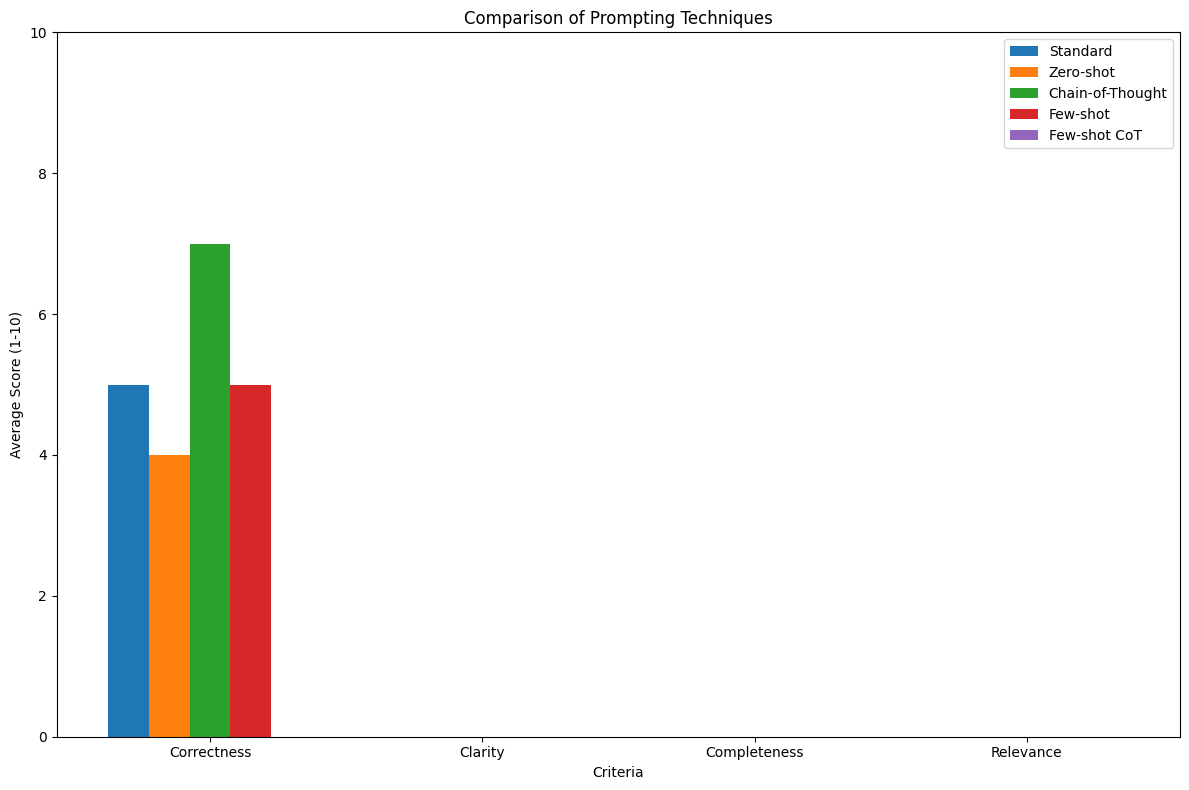

<Figure size 640x480 with 0 Axes>

In [32]:
def extract_scores_from_evaluation(evaluation_text):
    """
    Extract numerical scores from LLM evaluation text.
    This is a simplified implementation and might need refinement.

    Args:
        evaluation_text (str): Text containing evaluations

    Returns:
        dict: Dictionary of technique to scores
    """
    import re

    # Define the techniques we're looking for
    technique_names = ["Standard", "Zero-shot", "Chain-of-Thought", "Few-shot", "Few-shot CoT"]

    # Initialize results
    scores = {technique: {} for technique in technique_names}

    # Look for patterns like "Technique: X/10" or "Technique - X/10"
    for technique in technique_names:
        # Find all instances where the technique name is followed by numbers
        pattern = fr'{technique}[^0-9]*(\d+)(?:/10)?'
        matches = re.findall(pattern, evaluation_text)

        if matches:
            # Assume first match is for correctness, second for clarity, etc.
            criteria = ["Correctness", "Clarity", "Completeness", "Relevance"]
            for i, score in enumerate(matches[:len(criteria)]):
                try:
                    scores[technique][criteria[i]] = int(score)
                except ValueError:
                    scores[technique][criteria[i]] = 0

    return scores


def plot_evaluation_results(evaluation_results):
    """
    Plot evaluation results for visual comparison.

    Args:
        evaluation_results (list): Results from run_evaluation

    Returns:
        None (displays plots)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract scores for each task
    all_scores = []
    technique_names = []

    for result in evaluation_results:
        llm_eval = result['metrics']['llm_evaluation']
        scores = extract_scores_from_evaluation(llm_eval)
        all_scores.append(scores)

        # Get technique names if not already set
        if not technique_names and scores:
            technique_names = list(scores.keys())

    # Aggregate scores across tasks
    agg_scores = {technique: {criterion: [] for criterion in ["Correctness", "Clarity", "Completeness", "Relevance"]}
                  for technique in technique_names}

    for scores in all_scores:
        for technique in technique_names:
            if technique in scores:
                for criterion, score in scores[technique].items():
                    agg_scores[technique][criterion].append(score)

    # Calculate averages
    avg_scores = {technique: {criterion: np.mean(scores) if scores else 0
                              for criterion, scores in criteria_scores.items()}
                  for technique, criteria_scores in agg_scores.items()}

    # Plot the results
    criteria = ["Correctness", "Clarity", "Completeness", "Relevance"]

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(len(criteria))
    width = 0.15
    multiplier = 0

    for technique, scores in avg_scores.items():
        offset = width * multiplier
        values = [scores.get(criterion, 0) for criterion in criteria]
        ax.bar(x + offset, values, width, label=technique)
        multiplier += 1

    ax.set_xlabel('Criteria')
    ax.set_ylabel('Average Score (1-10)')
    ax.set_title('Comparison of Prompting Techniques')
    ax.set_xticks(x + width * (len(avg_scores) - 1) / 2)
    ax.set_xticklabels(criteria)
    ax.legend(loc='best')
    ax.set_ylim(0, 10)

    plt.tight_layout()
    plt.show()

    # You can also save the figure
    plt.savefig('prompting_techniques_comparison.png')

# Plot the results
plot_evaluation_results(evaluation_results)